<a href="https://colab.research.google.com/github/PsorTheDoctor/Sekcja-SI/blob/master/neural_networks/ConvRNN/video_prediction_conv_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Konwolucyjne LSTM: Przewidywanie następnej klatki

In [1]:
import os
import numpy as np
from PIL import Image, ImageSequence, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
# from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

def gif2array(path):
  # Wymiary zostały dobrane analogicznie do moving MNIST (n, 20, 64, 64)
  max_frames = 20
  resolution = (64, 64)
  array = []
  gif = Image.open(path)

  idx = 0
  for frame in ImageSequence.Iterator(gif):

    filename = '{}_{}.png'.format(os.path.basename(path)[:-4], idx)
    frame = frame.resize(resolution)
    frame.save(filename)
    frame = np.array(Image.open(filename))
    array.append(frame)
    os.remove(filename)
    idx += 1
    if idx == max_frames:
      break

  return np.asarray(array)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/moving-gif/train/'

x = gif2array(path + '00111.gif')
print(x.shape)

(17, 64, 64)


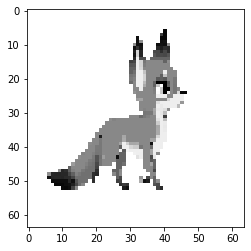

In [5]:
plt.imshow(x[0, :, :], cmap='gray_r')

In [6]:
path = '/content/drive/MyDrive/moving-gif/'
max_frames = 20

def create_dataset(path):
  dataset = []

  for filename in os.listdir(path):
    full_path = os.path.join(path, filename)

    if os.path.isfile(full_path):
      if filename[-4:] == '.gif':
        x = gif2array(full_path)

        # Dodanie paddingu w postaci pustych klatek dla n < max_frames
        # (n, 64, 64) -> (max_frames, 64, 64)
        if x.shape[0] < max_frames:
          zeros = np.zeros((max_frames - x.shape[0], 64, 64))
          x = np.concatenate((x, zeros), axis=0)
        dataset.append(x)

  return np.asarray(dataset)

train_dataset = create_dataset(path + 'train/')
test_dataset = create_dataset(path + 'test/')
print(train_dataset.shape)
print(test_dataset.shape)

(900, 20, 64, 64)
(100, 20, 64, 64)


In [7]:
# train_dataset = np.swapaxes(train_dataset, 0, 1)
# test_dataset = np.swapaxes(test_dataset, 0, 1)

train_dataset = np.expand_dims(train_dataset, axis=-1)
test_dataset = np.expand_dims(test_dataset, axis=-1)

train_dataset = train_dataset / 255
test_dataset = test_dataset / 255

def create_shifted_frames(data):
  x = data[:, 0 : data.shape[1] - 1, :, :]
  y = data[:, 1 : data.shape[1], :, :]
  return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(test_dataset)

print('Zbiór treningowy: ' + str(x_train.shape) + ', ' + str(y_train.shape))
print('Zbiór walidacyjny: ' + str(x_val.shape) + ', ' + str(y_val.shape))

Zbiór treningowy: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Zbiór walidacyjny: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


##Wizualizacja danych

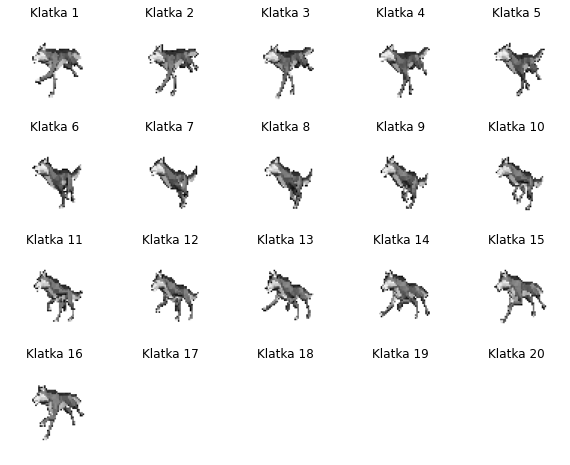

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
  ax.imshow(train_dataset[data_choice][idx].reshape(64, 64), cmap='gray_r')
  ax.set_title(f'Klatka {idx + 1}')
  ax.axis('off')

plt.show()

##Budowa modelu

In [10]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu"
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu"
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(loss=keras.losses.binary_crossentropy, 
              optimizer=keras.optimizers.Adam())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 64, 64, 1)] 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 64, 64, 64)  33024     
_________________________________________________________________
conv3d (Conv3D)              (None, None, 64, 64, 1)   1729  

##Trening modelu

In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5)

epochs = 10
batch_size = 5

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
180/180 [==============================] - 470s 2s/step - loss: 0.0958 - val_loss: 0.2265
Epoch 2/10
180/180 [==============================] - 444s 2s/step - loss: 0.0593 - val_loss: 0.1720
Epoch 3/10
180/180 [==============================] - 439s 2s/step - loss: 0.0563 - val_loss: 0.1505
Epoch 4/10
180/180 [==============================] - 439s 2s/step - loss: 0.0548 - val_loss: 0.1176
Epoch 5/10
180/180 [==============================] - 438s 2s/step - loss: 0.0541 - val_loss: 0.0884
Epoch 6/10
180/180 [==============================] - 443s 2s/step - loss: 0.0542 - val_loss: 0.0705
Epoch 7/10
180/180 [==============================] - 439s 2s/step - loss: 0.0537 - val_loss: 0.0628
Epoch 8/10
180/180 [==============================] - 438s 2s/step - loss: 0.0535 - val_loss: 0.0598
Epoch 9/10
180/180 [==============================] - 437s 2s/step - loss: 0.0536 - val_loss: 0.0591
Epoch 10/10
180/180 [==============================] - 442s 2s/step - loss: 0.0533 - val_lo

##Wizualizacja predykcji klatek

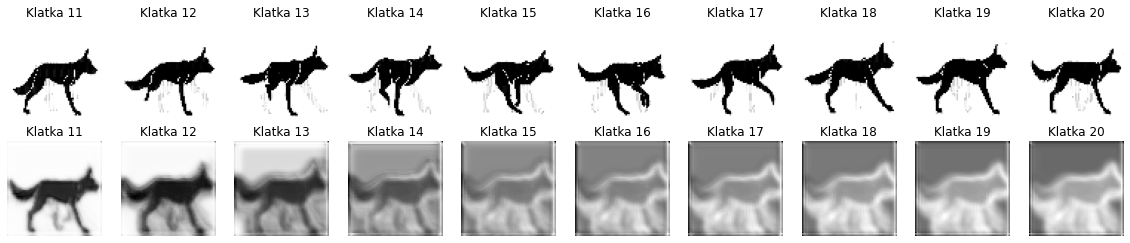

In [32]:
from IPython.display import Image, display

example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]

# Wybranie pierwszych / ostatnich 10 klatek z przykładu
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predykcja nowych 10 klatek
for _ in range(10):
  new_pred = model.predict(np.expand_dims(frames, axis=0))
  new_pred = np.squeeze(new_pred, axis=0)
  predicted_frame = np.expand_dims(new_pred[-1, ...], axis=0)

  frames = np.concatenate((frames, predicted_frame), axis=0)

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Wyświetlenie oryginalnych klatek
for idx, ax in enumerate(axes[0]):
  ax.imshow(np.squeeze(original_frames[idx]), cmap='gray_r')
  ax.set_title(f'Klatka {idx + 11}')
  ax.axis('off')

# Wyświetlenie nowych klatek
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
  ax.imshow(np.squeeze(new_frames[idx]), cmap='gray_r')
  ax.set_title(f'Klatka {idx + 11}')
  ax.axis('off')

plt.show()

##Wizualizacja predykcji wideo

In [28]:
examples = test_dataset[np.random.choice(range(len(test_dataset)), size=5)]

predicted_videos = []
for example in examples:
  # Odwrócenie kolorów
  example = np.ones(example.shape) - example

  # Wybranie pierwszych / ostatnich 10 klatek z przykładu
  frames = example[:10, ...]
  original_frames = example[10:, ...]
  new_preds = np.zeros(shape=(10, *frames[0].shape))

  # Predykcja nowych 10 klatek
  for i in range(10):
    frames = example[:10 + i + 1, ...]
    new_pred = model.predict(np.expand_dims(frames, axis=0))
    new_pred = np.squeeze(new_pred, axis=0)
    predicted_frame = np.expand_dims(new_pred[-1, ...], axis=0)

    new_preds[i] = predicted_frame
  
  for frame_set in [original_frames, new_preds]:
    # Tworzenie GIFa z wybranych klatek wideo
    current_frames = np.squeeze(frame_set)
    current_frames = current_frames[..., np.newaxis] * np.ones(3)
    current_frames = (current_frames * 255).astype(np.uint8)
    current_frames = list(current_frames)

    # Tworzenie GIFa z klatek
    with io.BytesIO() as gif:
      imageio.mimsave(gif, current_frames, 'GIF', fps=5)
      predicted_videos.append(gif.getvalue())

# Wyświetlenie wideo
print('Oryginał\tPredykcja')
for i in range(0, len(predicted_videos), 2):
  # Tworzenie i wyświetlenie "HBox"
  box = HBox(
      [widgets.Image(value=predicted_videos[i]),
       widgets.Image(value=predicted_videos[i + 1])
      ]
  )
  display(box)


Oryginał	Predykcja
